this notebook contains the code used to create the time evolution plots of the Loschmidt echo shown in the thesis.
The algorithm is primarily based on DOI:10.1038/s41534-021-00420-3

In [1]:
from copy import deepcopy
from numpy.linalg import matrix_power
from scipy.linalg import eig
import tqdm
import os

In [2]:
%load_ext autoreload
%autoreload 1
%aimport library
from library import *

In [3]:
np.random.seed(9)
U_param_values = np.random.random(12)
mps = iMPS(create_V_gate("V", 1), create_U_gate("U", 1,1, reps=3), U_param_values)
mps.V_optimization_kwargs["tolerance"] = 1e-9
braMPS = iMPS(create_V_gate("V'", 1), create_U_gate("U'", 1,1,reps=3), U_param_values)

# Plot results

## get U params

In [4]:
all_mps_list_for_comparison = []
names_list_for_comparison = []

In [5]:
# load all_mps from earlier
names_list_for_comparison=['third_hamiltonian_with_quench__eigenvalue^1_overlap__optimizing_l_tn__,g=1-.2_with_zz:1__dt=.01_BFGS',
                           'third_hamiltonian_with_quench__eigenvalue^1_overlap__optimizing_l_tn__,g=1-.2_with_zz:1__dt=.001_BFGS',
                            'third_hamiltonian_with_quench__eigenvalue^1_overlap__optimizing_l_tn__,g=1-.2_with_zz:1__dt=.01_Nelder-Mead',
                           'third_hamiltonian_with_quench__eigenvalue^5_overlap__classically__,g=1-.2_with_zz:1__dt=.01_Nelder-Mead',
                           'third_hamiltonian_with_quench__eigenvalue^1_overlap__classically__,g=1-.2_with_zz:1__dt=.01_BFGS']

for name in names_list_for_comparison:
    all_U_params = np.genfromtxt(f"results/{name}__U_params.csv", delimiter=",")
    all_mps = [deepcopy(mps) for i in range(len(all_U_params))]
    for i, mps_ in enumerate(all_mps):
        mps_.set_U_params(all_U_params[i])
    all_mps_list_for_comparison.append(all_mps)


In [6]:
g0, g1 = 1, .2

In [7]:
names_list_for_comparison

['third_hamiltonian_with_quench__eigenvalue^1_overlap__optimizing_l_tn__,g=1-.2_with_zz:1__dt=.01_BFGS',
 'third_hamiltonian_with_quench__eigenvalue^1_overlap__optimizing_l_tn__,g=1-.2_with_zz:1__dt=.001_BFGS',
 'third_hamiltonian_with_quench__eigenvalue^1_overlap__optimizing_l_tn__,g=1-.2_with_zz:1__dt=.01_Nelder-Mead',
 'third_hamiltonian_with_quench__eigenvalue^5_overlap__classically__,g=1-.2_with_zz:1__dt=.01_Nelder-Mead',
 'third_hamiltonian_with_quench__eigenvalue^1_overlap__classically__,g=1-.2_with_zz:1__dt=.01_BFGS']

## plot values of U parameter

Those where not shown in the thesis. They are usefull to see how stable the optimization was.

Text(0.5, 1.0, 'third hamiltonian with quench  eigenvalue^1 overlap  classically  ,g=1-.2 with zz:1  dt=.01 BFGS')

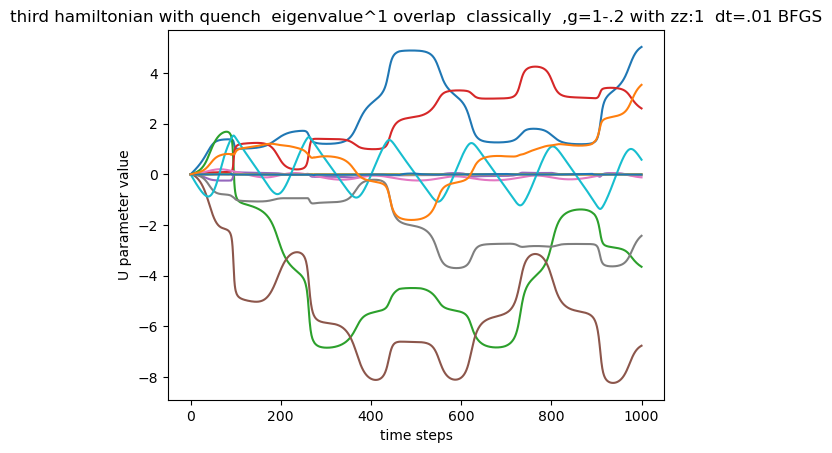

In [8]:
all_U_params = np.array([list(mps.U_params.values()) for mps in all_mps_list_for_comparison[4]])
plt.plot(all_U_params-all_U_params[0])
plt.xlabel("time steps")
plt.ylabel("U parameter value")
plt.title(name.replace("_", " "))

Text(0.5, 1.0, 'third hamiltonian with quench  eigenvalue^1 overlap  classically  ,g=1-.2 with zz:1  dt=.01 BFGS')

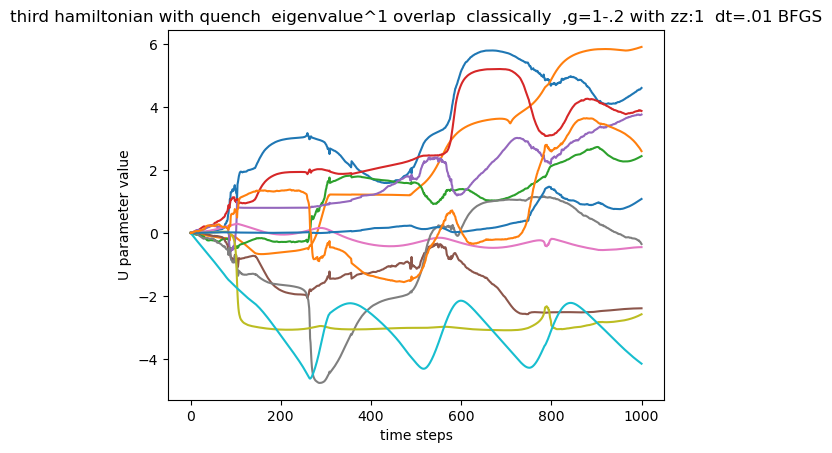

In [9]:
# corresponding plot for names[2]. (needs that names[2] was loaded last to produce this plot)
all_U_params = np.array([list(mps.U_params.values()) for mps in all_mps_list_for_comparison[2]])
plt.plot(all_U_params-all_U_params[0])
plt.xlabel("time steps")
plt.ylabel("U parameter value")
plt.title(name.replace("_", " "))

## estimate scalar products (Loschmidt)
the following two implementations should give the same results and did so in my tests.

In [10]:
from scipy.linalg import eig, eigvals
def scalar_prod(ketMPS, braMPS):
    # in reality it gets the largest eigenvalue of the transfer matrix.
    # this eval to the power of the system size is the scalar product.
    # for iMPS that would always be either 1 or 0.
    id_qc = QuantumCircuit(2)
    transfer = get_transfer_matrix(ketMPS, braMPS, id_qc)
    eval = eigvals(transfer)
    #print(np.round(np.log10(np.abs(eval)), 3))
    #print(np.round(np.imag(eval[0]), 3))

    return np.max(np.sqrt(np.abs(eval)))

In [11]:
from scipy.linalg import eig, eigvals
def scalar_prod(ketMPS, braMPS):
    # in reality it gets the largest eigenvalue of the transfer matrix.
    # this eval to the power of the system size is the scalar product.
    # for iMPS that would always be either 1 or 0.
    ket_U_mat = ketMPS.U_mat.to_matrix().T.reshape((2,)*4)[0]
    bra_U_mat = braMPS.Uinv_mat.to_matrix().T.reshape((2,)*4)[:,:,0,:]
    transfer = np.tensordot(ket_U_mat, bra_U_mat, (2,1))
    transfer = np.swapaxes(np.swapaxes(transfer, 1,3), 2,3).reshape((4,4)).T
    #print(transfer)
    
    eval = eigvals(transfer)
    #print(np.round(np.log10(np.abs(eval)), 3))
    #print(np.round(np.imag(eval[0]), 3))

    return np.max(np.abs(eval))

In [12]:
def get_scalar_products(mps_list):
    return np.array([scalar_prod(mps_list[0], mps_list[i]) for i in range(len(mps_list))])
def get_t(mps_index, delta_t = .01):
    return np.linspace(0, len(all_mps_list_for_comparison[mps_index])*delta_t, len(all_mps_list_for_comparison[mps_index]))

### compute scalar products

In [13]:
# this will raise an error, since the files have already been written.
for name, all_mps in zip(names_list_for_comparison, all_mps_list_for_comparison):
    scalar_products = -np.log(get_scalar_products(all_mps)**2)
    file_name = f"results/{name}__Loschmidt_Echos.csv"
    assert not os.path.exists(file_name), f"file {file_name} exists!!!"
    np.savetxt(file_name, scalar_products, delimiter=",")

AssertionError: file results/third_hamiltonian_with_quench__eigenvalue^1_overlap__optimizing_l_tn__,g=1-.2_with_zz:1__dt=.01_BFGS__Loschmidt_Echos.csv exists!!!

# final plots for thesis

In [14]:
t = get_t(0)
print(g0, g1)
analytical_loschmidt = loschmidts(t, g0, g1)

1 0.2


/home/leo/Daten/.miniconda3/envs/qiskit-env/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:577: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


(0.0, 1.0)

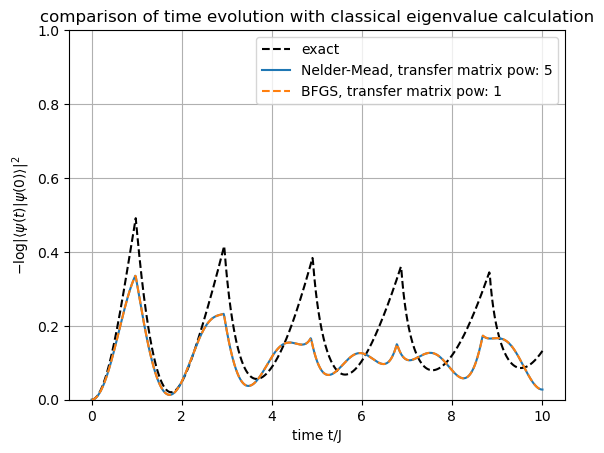

In [15]:
title = "comparison of time evolution with classical eigenvalue calculation"

plt.plot(t, analytical_loschmidt, label="exact", linestyle="dashed", color="black")
plt.plot(get_t(3)[:1001], -np.log(get_scalar_products(all_mps_list_for_comparison[3])**2)[:1001], label="Nelder-Mead, transfer matrix pow: 5")
plt.plot(get_t(4), -np.log(get_scalar_products(all_mps_list_for_comparison[4])**2), label="BFGS, transfer matrix pow: 1", linestyle="dashed")
plt.xlabel("time t/J")
plt.ylabel("$-\\log|\\langle \\psi(t) | \\psi(0)\\rangle |^2$")
plt.title(title)
plt.legend()
plt.grid()
#plt.xlim(-0.2,6.2)
plt.ylim(0,1)
#plt.savefig(f"results/{name[4]},{title}_LoschmidtEcho.pdf")

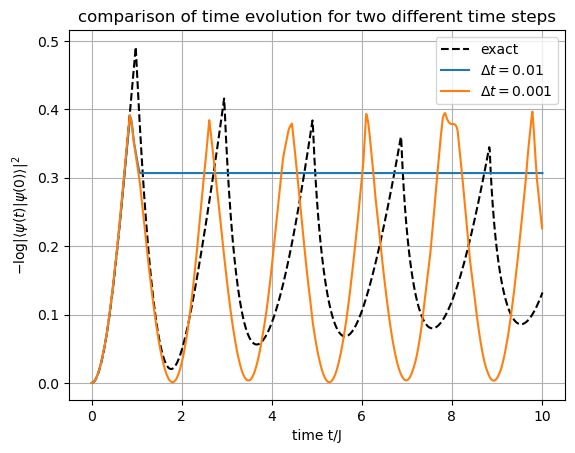

In [16]:
title = "comparison of time evolution for two different time steps"


plt.plot(t, analytical_loschmidt, label="exact", linestyle="dashed", color="black")
plt.plot(t, -np.log(get_scalar_products(all_mps_list_for_comparison[0])**2), label="$\\Delta t = 0.01$")
plt.plot(get_t(1, 0.001)
         , -np.log(get_scalar_products(all_mps_list_for_comparison[1])**2), label="$\\Delta t = 0.001$")
plt.xlabel("time t/J")
plt.ylabel("$-\\log|\\langle \\psi(t) | \\psi(0)\\rangle |^2$")
plt.title(title)
plt.legend()
plt.grid()
#plt.savefig(f"results/{name[1]},{title}_LoschmidtEcho.pdf")

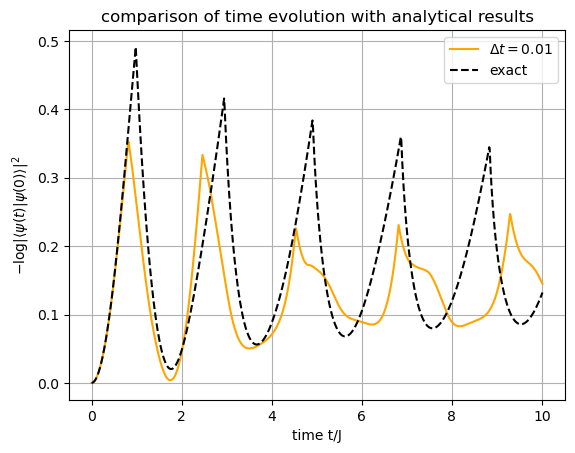

In [17]:
title = "comparison of time evolution with analytical results"


plt.plot(t, -np.log(get_scalar_products(all_mps_list_for_comparison[2])**2), label="$\\Delta t = 0.01$", color="orange")
plt.plot(t, analytical_loschmidt, label="exact", linestyle="dashed", color="black")
plt.xlabel("time t/J")
plt.ylabel("$-\\log|\\langle \\psi(t) | \\psi(0)\\rangle |^2$")
plt.title(title)
plt.legend()
plt.grid()
#plt.savefig(f"results/{name[2]},{title}_LoschmidtEcho.pdf")